# 1. Set-up

To start, let's perform the necessary imports.

In [190]:
import os
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import add
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.random.seed(777)
tf.random.set_seed(777)


One of the best practices to be performed when doing a machine learning project is to define the constants together, thus facilitating further changes. Given that, let's define the batch size, the height and width of the images and the learning rate.

In [191]:
BATCH_SIZE = 32
IMG_HEIGHT = 240
IMG_WIDTH = 240
ALPHA = 2e-4
labels = ['PNEUMONIA', 'NORMAL']

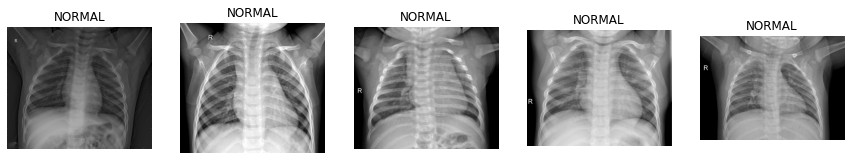

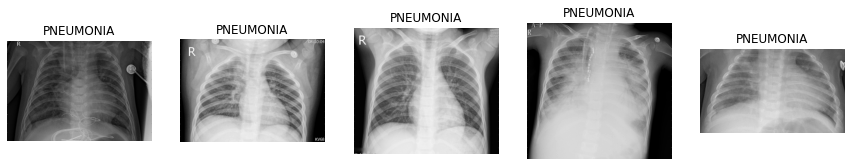

In [192]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
# Function to show samples from the dataset
def show_samples(category, dataset='train'):
    dir_path = os.path.join(base_dir, dataset, category)
    images = os.listdir(dir_path)[:5]  # Load the first 5 images
    plt.figure(figsize=(15, 10))
    
    for i, img in enumerate(images):
        img_path = os.path.join(dir_path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category}")
        plt.axis('off')
    
    plt.show()

# Show samples from the training set before preprocessing
show_samples('NORMAL')
show_samples('PNEUMONIA')

# 2. Preprocessing functions

In [193]:
def normalize_image(img):
    return img / 255.0

def resize_image(img, size=(IMG_HEIGHT, IMG_WIDTH)):
    return cv2.resize(img, size)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def noise_reduction(image, kernel_size=(3, 3), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def sharpen_edges(image):
    kernel_sharpening = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel_sharpening)

def process_image(img):
    equalized_img = histogram_equalization(img)
    denoised_img = noise_reduction(equalized_img)
    sharpened_img = sharpen_edges(denoised_img)
    resized_img = resize_image(sharpened_img)
    normalized_img = normalize_image(resized_img)
    return normalized_img

def process_images_in_directory(directory, output_directory, process_func):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):  # Skip files that are not directories
            continue

        output_category_path = os.path.join(output_directory, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                processed_img = process_func(img)
                output_img_path = os.path.join(output_category_path, filename)
                cv2.imwrite(output_img_path, (processed_img * 255).astype(np.uint8))

In [194]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
val_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'
test_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
output_base_dir = './processed_data'

In [195]:
# Apply preprocessing to the entire dataset
process_images_in_directory(train_dir, os.path.join(output_base_dir, 'train'), process_image)
process_images_in_directory(val_dir, os.path.join(output_base_dir, 'val'), process_image)
process_images_in_directory(test_dir, os.path.join(output_base_dir, 'test'), process_image)

print("Processing completed.")

Processing completed.


Processed Normal images:


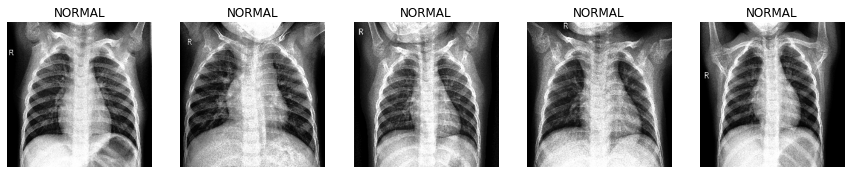

Processed Pneumonia images:


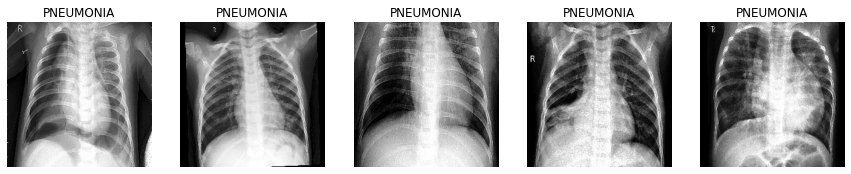

In [196]:
def show_processed_samples(category, dataset='train'):
    dir_path = os.path.join(output_base_dir, dataset, category)
    images = os.listdir(dir_path)[:5]
    plt.figure(figsize=(15, 10))

    for i, img in enumerate(images):
        img_path = os.path.join(dir_path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category}")
        plt.axis('off')

    plt.show()

print("Processed Normal images:")
show_processed_samples('NORMAL')
print("Processed Pneumonia images:")
show_processed_samples('PNEUMONIA')

# 3. Load the data



In [197]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                data.append([img_arr, class_num])
            except Exception as e:
                pass

    return np.array(data)

In [198]:
train = get_data('/kaggle/working/processed_data/train')
test = get_data('/kaggle/working/processed_data/test')
val = get_data('/kaggle/working/processed_data/val')

In [199]:
print(f"{[y for _, y in train].count(1)} PNEUMONIA IMAGES IN TRAINING SET")
print(f"{[y for _, y in train].count(0)} NORMAL IMAGES IN TRAINING SET")

1341 PNEUMONIA IMAGES IN TRAINING SET
3875 NORMAL IMAGES IN TRAINING SET


In [200]:
print(f'Images in TRAINING SET: {train.shape[0]}')
print(f'Images in VALIDATION SET: {val.shape[0]}')
print(f'Images in TEST SET: {test.shape[0]}')

Images in TRAINING SET: 5216
Images in VALIDATION SET: 16
Images in TEST SET: 624


In [201]:
train = np.append(train, val, axis=0)
train, val = train_test_split(train, test_size=.20, random_state=777)

In [202]:
x_train = train[:, 0]
y_train = train[:, 1].astype(int)

x_test = test[:, 0]
y_test = test[:, 1].astype(int)

x_val = val[:, 0]
y_val = val[:, 1].astype(int)

# 4. Process the data

In [219]:
# Add channel dimension to image arrays
x_train = x_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
x_val = x_val.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
x_test = x_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

# Initialize ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.2, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    horizontal_flip=False,  
    vertical_flip=False)

# Fit the ImageDataGenerator
datagen.fit(x_train)


Well, now we have to solve the previously mentioned problem of data imbalance. There are several possible approaches to be taken but we will choose to simply assign different weights to the classes.

These weights will be used in the future as a parameter in the fit of our model and, as well described in the official documentation of Keras, assigning this person can be useful to tell the model to "pay more attention" to samples from an under-represented class.


We could perform the calculation of weights manually using the formula but sklearn has a function dedicated to it.

In [220]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 0.6774036905147297, 1: 1.9092153284671534}


# 5. Build the model

Finally we come to the most interesting part for some people: the model creation phase.

In [221]:
def block(inputs, filters, stride):
    conv_0 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(stride, stride), padding='same')(inputs)
    conv_0 = layers.BatchNormalization()(conv_0)
    conv_0 = layers.ReLU()(conv_0)
    
    conv_1 = layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv_0)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.ReLU()(conv_1)
    
    skip = layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=(stride, stride), padding='same')(inputs)
    skip = layers.BatchNormalization()(skip)
    
    added = layers.add([conv_1, skip])
    pool = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(added)
    
    return pool

In [222]:
input_size = (IMG_HEIGHT, IMG_WIDTH, 1)

inputs = tf.keras.Input(shape=input_size, name='input')

y_0 = block(inputs, 16, 2)
y_1 = block(y_0, 32, 1)
y_2 = block(y_1, 48, 1)
y_3 = block(y_2, 64, 1)
y_4 = block(y_3, 80, 1)

gap = layers.GlobalMaxPooling2D()(y_4)
dense = layers.Dense(2, activation='relu')(gap)

outputs = layers.Dense(1, activation='sigmoid')(dense)

In [223]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pneumonia_wnet")
model.summary()

Model: "pneumonia_wnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 120, 120, 16) 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 120, 120, 16) 64          conv2d_150[0][0]                 
__________________________________________________________________________________________________
re_lu_70 (ReLU)                 (None, 120, 120, 16) 0           batch_normalization_105[0][0]    
_____________________________________________________________________________________

# 6. Train the model

We will define some callbacks like ReduceLROnPlateau and EarlyStopping that will help us to have a faster training. 

As defined at Keras API reference, reduce learning rate when a metric has stopped improving nd it's usefull because models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. Also, early stopping is a form of regularization and thus will help us in preventing overfitting.


In [224]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.7, min_delta=ALPHA, patience=7, verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

In [225]:
CALLBACKS = [lr_reduce, early_stopping_cb]

For our metrics, we want to use accuracy, precision and recall. This choices were made because:
* Accuracy, despite being the most widely used metric, give us a quite illusory information about how good our model are performing, since we have the problem of imbalanced data.
* Precision give us the ratio tp/(tp+fp) or in a intuitively definiton the ability of the classifier not to label as positive a sample that is negative.
* Recall give us the ratio tp/(tp+fn) or in a intuitively the ability of the classifier to find all the positive samples. 

In [226]:
METRICS = ['accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')]

As optimizer we will choose Adam, because it combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. As loss, since we have just two possible labels, we are going to use binary crossentropy.

In [227]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=ALPHA),
    loss='binary_crossentropy', 
    metrics=METRICS
)

Let's fit our model now. It is important to remember here to use the weights for classes previously found by us.

In [228]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = BATCH_SIZE),
                    steps_per_epoch=x_train.shape[0]/BATCH_SIZE, 
                    validation_data = (x_val, y_val),
                    validation_steps=x_val.shape[0]/BATCH_SIZE,
                    callbacks = CALLBACKS,
                    class_weight = weights,
                    epochs = 30)

Epoch 1/30
131/130 [==============================] - 17s 128ms/step - loss: 0.6571 - accuracy: 0.8110 - precision: 0.6170 - recall: 0.7336 - val_loss: 0.5066 - val_accuracy: 0.7564 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
131/130 [==============================] - 16s 123ms/step - loss: 0.4585 - accuracy: 0.8781 - precision: 0.7148 - recall: 0.8896 - val_loss: 0.3036 - val_accuracy: 0.8720 - val_precision: 0.8563 - val_recall: 0.5652
Epoch 3/30
131/130 [==============================] - 16s 124ms/step - loss: 0.4289 - accuracy: 0.9164 - precision: 0.7932 - recall: 0.9206 - val_loss: 0.3285 - val_accuracy: 0.8539 - val_precision: 0.6724 - val_recall: 0.7708
Epoch 4/30
131/130 [==============================] - 16s 124ms/step - loss: 0.4154 - accuracy: 0.9297 - precision: 0.8292 - recall: 0.9215 - val_loss: 0.2618 - val_accuracy: 0.9255 - val_precision: 0.8458 - val_recall: 0.8458
Epoch 5/30
131/130 [==============================] - 16s 122ms/step - loss: 0.4086 

One of the most important things to do when it comes to training models is to visualize their performance evolution. In this sense, we will plot the value of accuracy, precision, recall and AUC over the epochs.

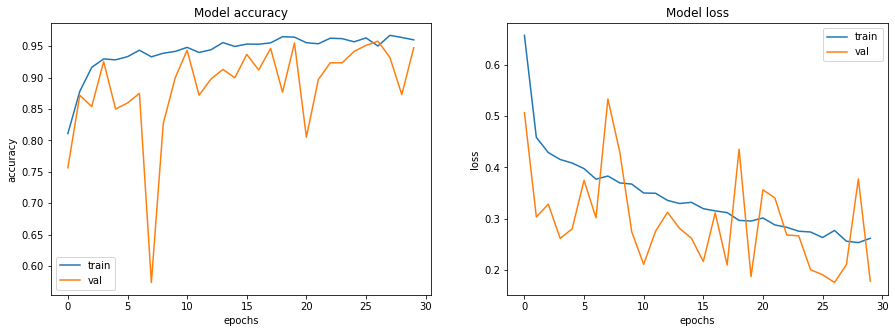

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 7. Evaluate the model

Now, it's time to try to generate predictions from data never seen before and check the performance of our model. 


In [230]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.4596 - accuracy: 0.8574 - precision: 0.9096 - recall: 0.6880   
Loss of the model is -  0.4596312642097473
20/20 [==============================] - 0s 7ms/step - loss: 0.4596 - accuracy: 0.8574 - precision: 0.9096 - recall: 0.6880   
Accuracy of the model is -  85.73718070983887 %


With these values of accuracy, precision and recall, it is clear that the model used in this kernel presents itself as a solid and extremely efficient architecture for the problem in question.

Let's take a deep look at the results.

In [231]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

In [232]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.96      0.89       390
   Normal (Class 1)       0.91      0.69      0.78       234

           accuracy                           0.86       624
          macro avg       0.87      0.82      0.84       624
       weighted avg       0.86      0.86      0.85       624



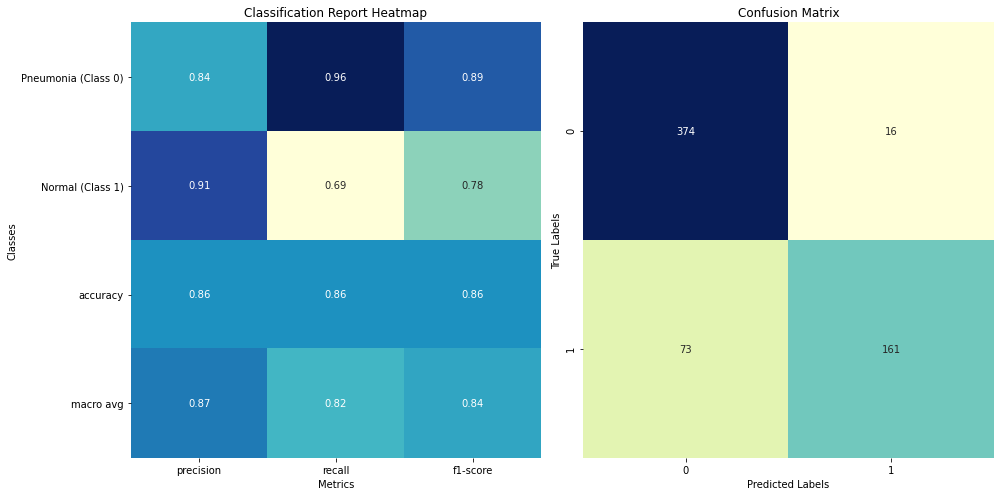

In [233]:
# Generate classification report
class_report = classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)'], output_dict=True)
df_class_report = pd.DataFrame(class_report).transpose()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot classification report heatmap
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.heatmap(df_class_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt='.2f', cbar=False)
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Plot confusion matrix heatmap
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()
